# Trabalho 2 de Aprendizado de Máquina

Trabalho sobre Classificadores.

- **Aluna:** Bárbara Neves
- **Matrícula:** 388713

## Bibliotecas

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler

## Implementação

### 1. Métodos

#### a. Regressão Logística – Gradiente Descendente

In [2]:
class LogisticRegression():
    def __init__(self):
        pass
    
    # Calcula o y_pred
    def logistic_function(self, B, X):
        return 1/(1 + np.exp(-X @ B))

    # Calcula a função de loss/custo
    def logistic_loss(self, y, y_pred):
        return np.mean(-y * np.log(y_pred) - (1 - y)*np.log(1 - y_pred)) 

    def fit(self, X, y, epochs, alpha):
        n = X.shape[0]           
        loss = [] 
        
        if len(y.shape) == 1:   
            y = y[:, None]
        
        B = np.zeros((X.shape[1], y.shape[1]))
                  
        for epoch in range(epochs):
            y_pred = self.logistic_function(B, X) 
            ei = y - y_pred   
                  
            B += alpha * np.sum(X.T @ ei)/n
            loss.append(self.logistic_loss(y, y_pred)) 
                  
        self.B = B
        self.loss = loss

    def predict(self, X):
        y_pred = self.logistic_function(self.B, X)
        
        return [1 if i > 0.55 else 0 for i in y_pred] #Convertendo as probabilidades para 0's e 1's
                  
    def loss_history(self):
        return self.loss

#### b. Naive Bayes Gaussiano 

In [3]:
class GaussianNB():
    def __init__(self):
        pass 

    def fit(self, X, y):
        classes = np.unique(y)
        K = classes.shape[0]
        D = X.shape[1]
        class_prior = np.array([np.sum(y == k) for k in classes])/y.shape[0] #Proporção das classes

        mu = np.zeros((D, K))
        var = np.zeros((D, K)) #Variância
        
        for k in classes:
            k = int(k)
            x_k = X[y == k]
            mu[:, k] = np.mean(x_k, axis=0)
            var[:, k] = np.sum((x_k - mu[:, k])**2, axis=0) / x_k.shape[0]
            var[:, k] += np.mean(var[:, k]) * 10 ** -6

        model = {'classes': classes, 'K': K, 'D': D, 'class_prior': class_prior,
                 'mu': mu, 'var': var}

        self.model = model

    def predict(self, X):
        pred = []
        
        for i in range(X.shape[0]):
            prob_k = []
            for k in range(self.model['K']):
                prob_k.append(- 0.5 * np.sum(np.log(2 * np.pi * self.model['var'][:,k])) \
                     - 0.5 * np.sum((X[i,:] - self.model['mu'][:, k])**2 / self.model['var'][:, k]) \
                     + self.model['class_prior'][k])

            pred.append(self.model['classes'][np.argmax(prob_k)])

        return pred   

#### c. Discriminante Quadrático Gaussiano

In [4]:
class GaussianQD():
    def __init__(self):
        pass 

    def fit(self, X, y):
        classes = np.unique(y)
        K = classes.shape[0]
        D = X.shape[1]
        class_prior = np.array([np.sum(y == k) for k in classes])/y.shape[0] #Proporção das classes

        mu = np.zeros((D, K))
        var = np.zeros((D, D, K)) #Variância
        
        for k in classes:
            k = int(k)
            x_k = X[y == k]
            mu[:, k] = np.mean(x_k, axis=0)
            var[:, :, k] = (x_k - mu[:, k]).T @ (x_k - mu[:, k]) / x_k.shape[0]
            var[:, :, k] += np.eye(D) * np.mean(np.diag(var[:, :, k])) * 10 ** -6

        model = {'classes': classes, 'K': K, 'D': D, 'class_prior': class_prior,
                 'mu': mu, 'var': var}

        self.model = model

    def predict(self, X):
        pred = []
        
        for i in range(X.shape[0]):
            prob_k = []
            for k in range(self.model['K']):
                prob_k.append(- 0.5 * np.log(np.linalg.det(self.model['var'][:, :, k])) \
                     - 0.5 * (X[i, :] - self.model['mu'][:, k]).T @ np.linalg.inv(self.model['var'][:, :, k]) @ (X[i, :] - self.model['mu'][:, k]) \
                     + self.model['class_prior'][k])

            pred.append(self.model['classes'][np.argmax(prob_k)])

        return pred  

### 2. Função de acurácia

In [5]:
def accuracy_score(y_real, y_pred):
    return np.sum(y_pred == y_real)/y_real.shape[0]

### 3. Matriz de confusão 

In [6]:
def plot_confusion_matrix(y_true, y_pred, title, cmap=plt.cm.Reds):
    cm = confusion_matrix(y_true, y_pred) #Computar a matrix de confusão
    classes = [int(i) for i in np.unique(y_true)] #Classes

    fig, ax = plt.subplots(figsize=(8, 5))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)

    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=classes, 
           yticklabels=classes,
           title=title,
           ylabel='Verdadeiros',
           xlabel='Preditos')

    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    thresh = cm.max() / 2.0
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], 'd'), ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    
    return ax

### 4. Gráfico de dispersão com fronteira de separação

In [7]:
def plot_boundaries(X, y, clf, title, cmap=plt.cm.YlOrRd):
    markers = ('o', 'x')
    colors = ('firebrick', 'black')

    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                         np.arange(y_min, y_max, 0.02))
    
    Z = clf.predict(np.array([xx.ravel(), yy.ravel()]).T)
    Z = np.array(Z).reshape(xx.shape)
    
    plt.figure(figsize=(8, 5))
    plt.title(label=title)
    plt.contourf(xx, yy, Z, alpha=0.3, cmap=cmap)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], 
                    y=X[y == cl, 1], 
                    c=colors[idx],
                    marker=markers[idx], 
                    label='Class ' + str(int(cl)), 
                    edgecolor='black')
    plt.legend()
    plt.show()

### *5 (Extra). Visualização da Loss

In [8]:
def plot_loss_path(loss, title=None):
    plt.figure(figsize=(10, 5))
    
    plt.rcParams.update({'font.size': 14})
    plt.plot(range(1, len(loss)+1), loss, '-k', color='firebrick')
    
    plt.xlabel('Épocas', fontsize=14)
    plt.ylabel('Loss', fontsize=14)
    
    if title is not None:
        plt.title(title, fontsize=14)        
        
    plt.show()

## Conjunto de dados
### 1. Leitura do conjunto de dados: ``` trab2.data ```

In [9]:
df = pd.DataFrame(columns=['X_0', 'X_1', 'y'])

with open('data_trab2/ex2data1.txt', 'r') as f: 
    for line in f:
        try:
            line = float(line)
        except ValueError:
            pass
        split_line = line.split(',')
        df = df.append({
            'X_0': float(split_line[0]),
            'X_1': float(split_line[1]),
            'y': float(split_line[2])
        }, ignore_index=True)
        
df.head()

,X_0,X_1,y
0,34.623660,78.024693,0.0
1,30.286711,43.894998,0.0
2,35.847409,72.902198,0.0
3,60.182599,86.308552,1.0
4,79.032736,75.344376,1.0


### 2. X e y

A duas primeiras colunas são as características (X) e a última coluna é a variável alvo (y).

In [10]:
X = df.values[:, :-1]
y = df.values[:, -1]

X.shape, y.shape

((100, 2), (100,))

### 3. Divisão do conjunto de dados

Dividindo o conjunto de dados em 70% para treino e 30% para teste.

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

(X_train.shape, y_train.shape), (X_test.shape, y_test.shape)

(((70, 2), (70,)), ((30, 2), (30,)))

#### Normalização dos dados

Resolvi normalizar os dados apenas para demorar um pouco menos na geração dos gráficos de dispersão. Não teve nada a ver com otimizar a performance dos modelos (na verdade, ela continua a mesma mesmo com a normalização).

In [12]:
scaler = StandardScaler()

scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

## Relatório

### 1. Executar cada um dos modelos de classificação

#### Regressão Logística – Gradiente Descendente

Dado a experiência tida com o trabalho anterior, preferi escolher a quantidade das **épocas** e da **taxa de aprendizado (α)** analizando a função de custo. 

In [13]:
# Analisando melhor alpha
np.seterr(divide='ignore', invalid='ignore', over='ignore')

epochs = 100000
grid_search = np.logspace(-4, 0, 11) # Alpha
val_list = []

for i in range(grid_search.shape[0]):
    alpha = grid_search[i]

    LR_model = LogisticRegression() 
    LR_model.fit(X_train, y_train, epochs=epochs, alpha=alpha)
    
    y_pred = np.argmax(LR_model.predict(X_test))
    
    wrong_index_val = y_test != y_pred
    val_list.append(np.mean(wrong_index_val))

best_alpha = grid_search[np.argmin(val_list)] 
print("[LogisticRegression] Melhor modelo encontrado: alpha={}".format(best_alpha))

[LogisticRegression] Melhor modelo encontrado: alpha=0.0001


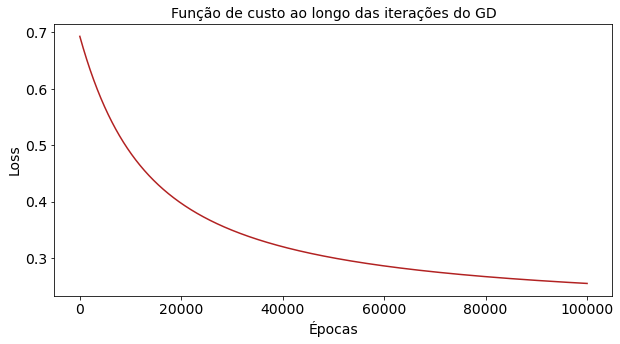

In [14]:
cls_models = {
    'LR': LogisticRegression()
}

cls_models['LR'].fit(X_train, y_train, epochs=epochs, alpha=best_alpha)

plot_loss_path(cls_models['LR'].loss_history(), 'Função de custo ao longo das iterações do GD')

#### Naive Bayes Gaussiano e Discriminante Quadrático Gaussiano

In [15]:
cls_models['GNB'] = GaussianNB()
cls_models['GQD'] = GaussianQD()

for k, v in cls_models.items():
    if(k != 'LR'):
        v.fit(X_train, y_train)

#### Predições

In [16]:
predictions = {'y_pred_' + k: v.predict(X_test) for k, v in cls_models.items()}

predictions.keys()

dict_keys(['y_pred_LR', 'y_pred_GNB', 'y_pred_GQD'])

In [17]:
print('Taxas de erro para o conjunto de teste:')
for i, j in zip(cls_models, predictions):
    wrong_index_test = predictions[j] != y_test
    print('[{}] = {}'.format(i, 100*np.mean(wrong_index_test)))

Taxas de erro para o conjunto de teste:
[LR] = 26.666666666666668
[GNB] = 20.0
[GQD] = 20.0


#### a. Acurácias

In [18]:
accs = {i: accuracy_score(y_test, predictions[j]) for i, j in zip(cls_models, predictions)}

print('Acurácias:')
for k, v in accs.items():
    print('{} = {}'.format(k, v))

Acurácias:
LR = 0.7333333333333333
GNB = 0.8
GQD = 0.8


#### b. Matrizes de confusão

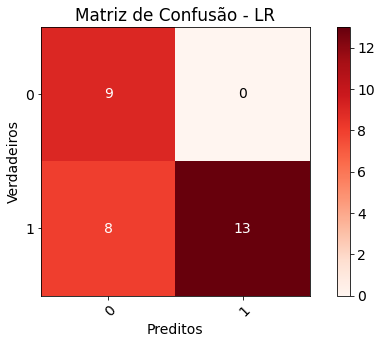

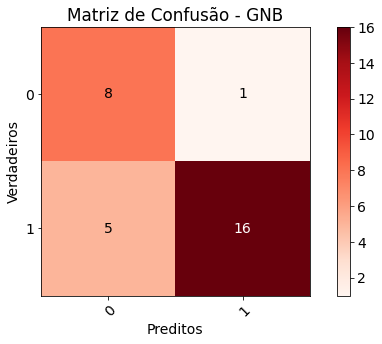

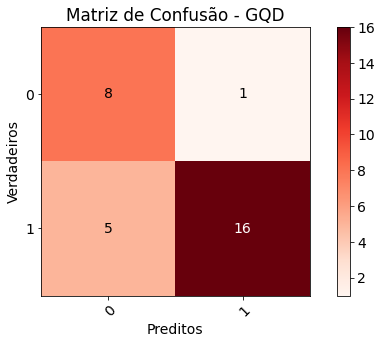

In [19]:
for i, j in zip(cls_models, predictions):
    plot_confusion_matrix(y_test, predictions[j], title='Matriz de Confusão - ' + i);

#### c. Gráficos de dispersão com fronteiras de separação

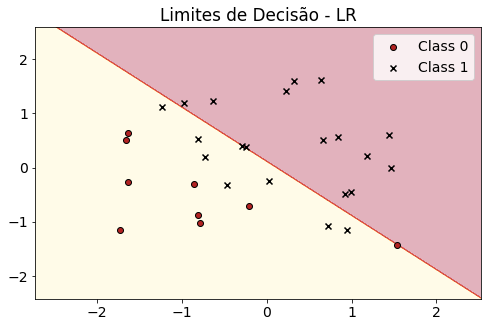

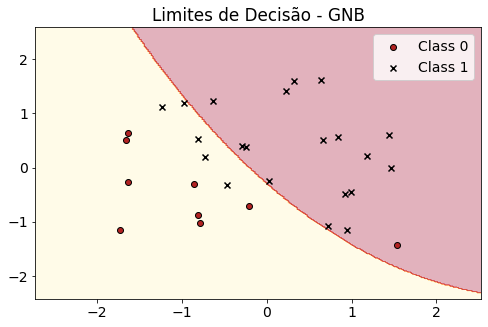

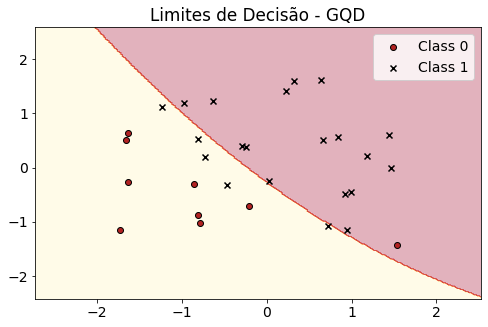

In [21]:
for k, v in cls_models.items():
    plot_boundaries(X_test, y_test, v, title='Limites de Decisão - ' + k);

### 2. O dado parece ser linearmente separável ou não?

Não, os dados não parecem ser linearmente separáveis. Mesmo que o conjunto de dados tenha apenas 2 classes, os resultados obtidos para o modelos de classificação foram bons. Isso também pode ser constatado olhando os gráficos de dispersão, já que não é possível passar uma reta para fazer a delimitação de uma classe para a outra. 

### 3. Quais dos métodos produziu fronteiras lineares?

De acordo com os gráficos de dispersão acima, o método que produziu uma fronteira linear (levemente curvada) foi a **Regressão Logística – Gradiente Descendente**.

### 4. Qual teve melhor acurácia?

Dois modelos obtiveram o maior valor de acurácia (**80%**): 
- **Naive Bayes Gaussiano**; e,
- **Discriminante Quadrático Gaussiano**.